# Validation of the different aspects of the model </a><a name='top'>

A few physical outputs from the model are evaluated here, and compared to observational data. These include SWE and height values above clearly identified snowpack layers, density profile, temperature profile, and total height of the snowpack.

Parameters are defined in the file **parameter.py**, to be adjusted before launching the notebook, but additional information must be filled in in [**this section**](#fill-in). Once these two sections are filled-in, the whole notebook may be run.
    
**WARNING:** the end date of the dataset may not correspond to the date of the snowpit, check what you are plotting!

## 0. Simulated snowpack creation

### Define parameters </a><a name='fill-in'>

In [1]:
dataset_file_name = 'pit_7_2023.nc'

save_figures = False
save_text_results = False
directory_to_save_figs_in = '/home/mabonnet/github/MB_little_awk/finalized/Results_pits_2023/'
fig_name_1 = 'pit__density_profile.png'
fig_name_2 = 'pit__temp_profile.png'

In [2]:
# Observations

# Get observational data from csv file

pit_nb = 7     # not an index
obs_file_name = '/home/mabonnet/Desktop/data/obs_data_2023_finse.csv'

sampling_length = 0.1   # depth between two samples of the snowpack, in meters
ref_layer_indices = [0, 3, 6, 9, 12]   # indices of the layers directly below ice interfaces
bottom_depth_ro = 0.1
bottom_depth_temp = 0
start_from_top = False

# SWE
observed_swe = []   # corresponding SWE above the reference layers
observed_ave_density = []

# Heights
observed_heights = []   # corresponding height above the reference layers
observed_total_height = 150


[Back to top section](#top)

## Create obs data from csv file

In [3]:
import pandas as pd

In [4]:
data_obs = pd.read_csv(obs_file_name)

obs_ro = list(data_obs.loc[data_obs.Pit_name==data_obs.Pit_name.unique()[pit_nb]].Density)
obs_ro.pop()
if type(obs_ro[0]) == float:
    obs_ro.pop(0)
    
obs_temp = list(data_obs.loc[data_obs.Pit_name==data_obs.Pit_name.unique()[pit_nb]].Temperature_corrected)
if type(obs_temp[0]) == float:
    obs_temp.pop(0)

In [5]:
# Density
observed_ro_profile = [float(i) for i in obs_ro[::-1]]    # Careful to put the data in the correct order, from bottom to top

# Temperature
observed_temp_profile = [float(i) for i in obs_temp[::-1]]     # Careful to put the data in the correct order, from bottom to top


### Simulation

In [6]:
# Imports

%run little_awk_functions.py
%run parameters.py

In get_met_forcing() - Warning: check the format of your file corresponds to the indices given in the functions (wind speed 5, surface temperature 7, time 0).


In [7]:
# Clean dataset

data_set_used = xr.open_dataset(dataset_file_name)

data_set_used = data_set_used.ffill(dim='time')

median_space_filtering(data_set_used, 5, x_span=7, y_span=7)
median_time_filtering(data_set_used, 11)

# Add the summer surface to the dataset

define_summer_surface(data_set_used, start_summer_surface, end_summer_surface)

# Redefine the zero of the dataset

data_set_used['snow_depth'] = data_set_used['snow_surface'] - data_set_used['summer_surface']


---> Median filtering in space with a window [5, 7]
---> Median filtering in time with a window of 11
---> Summer surface defined based on scans from 2022-10-07 to 2022-10-15


In [8]:
# Define dates

data_starting_date_in_ns = float(data_set_used.time.values[0])

data_starting_date_in_s = pd.to_datetime(data_set_used.time.values[0]).timestamp()
data_ending_date_in_s = pd.to_datetime(data_set_used.time.values[-1]).timestamp()
data_duration_in_s = data_ending_date_in_s - data_starting_date_in_s
nb_iterations = int(data_duration_in_s/dt + 1)

In [9]:
# Get timing of snow events

results = get_snow_events(data_set_used, x_isel, y_isel, time_window_std, std_threshold)
start_accumulation, start_erosion, end_accumulation, end_erosion = results[0], results[1], results[2], results[3]

# Convert end times into more manageable orders of magnitude (seconds)

end_accumulation_times = data_set_used.snow_depth.isel(x=x_isel, y=y_isel, time=end_accumulation)
end_accumulation_times = (pd.to_datetime(end_accumulation_times.time).astype(int) - data_starting_date_in_ns) / 1000000000  # in s

end_erosion_times = data_set_used.snow_depth.isel(x=x_isel, y=y_isel, time=end_erosion)
end_erosion_times = (pd.to_datetime(end_erosion_times.time).astype(int) - data_starting_date_in_ns) / 1000000000  # in s


In [10]:
# Simulate the snowpack

snowpack = simulate_snowpack_evolution(data_set_used, x_isel, y_isel, nb_iterations, max_nb_of_layers, end_accumulation_times, end_erosion_times,
                                       start_accumulation, end_accumulation, start_erosion, end_erosion, jj, dt, ro_layer, ro_water, ro_ice,
                                       t_old, tf, tsfc, dy_snow, age_layers, gamma, cp_snow, melt_flag, a1, a2, met_temp_data=met_temp, met_wind_data=met_wind,
                                       met_time_data=met_time)

ro_layer_evolution, depth_evolution, temperature_evolution = snowpack[0], snowpack[1], snowpack[2]


## 1. Events detection validation

This will be done by eye simply, most probably. Suggestions of what could be used for quantitative evaluation: number of events that match manually identified events (possibly divided by the total number of detected events), or use the measures used for the sensitivity tests.

## 2. Density and SWE validation

In [22]:
# print(len(simulated_ro_profile), observed_ro_profile)

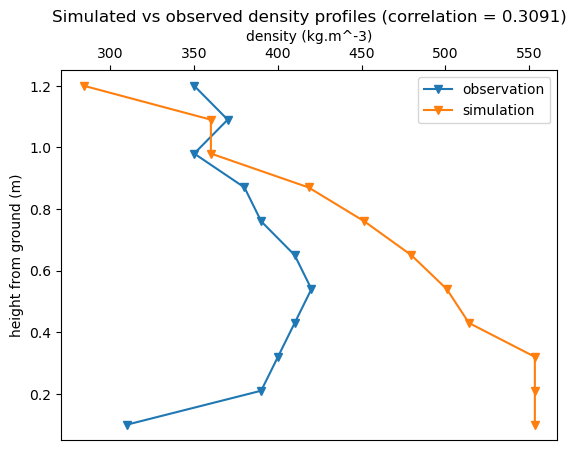

In [21]:
# Plot observed vs simulated density profiles

# Get profiles and correlation

observed_ro_profile.pop()
observed_ro_profile.pop()

# bottom_depth_ro = round( (len(observed_ro_profile)-1) * sampling_length, 1 )
simulated_ro_profile = density_profile(bottom_depth_ro, sampling_length, depth_evolution[-1], ro_layer_evolution[-1])
# simulated_ro_profile.pop()

correlation_ro = p_correl_measure(simulated_ro_profile, observed_ro_profile)

# Create figure

fig = plt.figure()
ax = fig.add_subplot()

if start_from_top:
    depths_array = np.linspace(0, -bottom_depth_ro, len(observed_ro_profile))
    ax.plot(list(reversed(observed_ro_profile)), depths_array, marker='v', label='observation')
    ax.plot(list(reversed(simulated_ro_profile)), depths_array, marker='v', label='simulation')
else:
    depths_array = np.linspace(bottom_depth_ro, bottom_depth_ro+len(observed_ro_profile)*sampling_length, len(observed_ro_profile))
    ax.plot(list(observed_ro_profile), depths_array, marker='v', label='observation')
    ax.plot(list(simulated_ro_profile), depths_array, marker='v', label='simulation')

ax.set_xlabel('density (kg.m^-3)')
ax.xaxis.tick_top()
ax.xaxis.set_label_position('top')

if start_from_top:
    ax.set_ylim(-bottom_depth_ro-sampling_length/2, sampling_length/2)
    ax.set_ylabel('depth from surface (m)')
else:
    ax.set_ylim(bottom_depth_ro-sampling_length/2, bottom_depth_ro + len(observed_ro_profile)*sampling_length + sampling_length/2)
    ax.set_ylabel('height from ground (m)')

plt.title('Simulated vs observed density profiles (correlation = ' + str(round(correlation_ro, 4)) + ')')
plt.legend()
plt.show()

In [ ]:
if save_figures:
    fig.savefig(directory_to_save_figs_in + fig_name_1, bbox_inches = 'tight')

In [ ]:
# Get SWE comparable values

simulated_swe = [get_data_from_ref(i, ro_layer_evolution[-1], depth_evolution[-1])[0] for i in ref_layer_indices]
simulated_ave_density = [get_data_from_ref(i, ro_layer_evolution[-1], depth_evolution[-1])[2] for i in ref_layer_indices]

## 3. Height of layers validation

In [ ]:
# Get height comparable values

simulated_heights = [get_data_from_ref(i, ro_layer_evolution[-1], depth_evolution[-1])[1] for i in ref_layer_indices]
simulated_total_height = sum(depth_evolution[-1][i] for i in range(len(depth_evolution[-1])))

In [ ]:
# Save height and SWE results in a .txt file

results_test = "Pit nb " + str(pit_nb) + ": \n \n Reference layers (indices): " + str(ref_layer_indices) + " and corresponding values (computed ABOVE the reference layers): \n Simulated SWE (m): " + str(simulated_swe) + ", \n Simulated average density (kg.m^-3): " + str(simulated_ave_density) + ", \n Simulated heights (m): " + str(simulated_heights) + " \n Simulated total height (m): " + str(simulated_total_height) + "\n \n"

if save_text_results:
    with open(directory_to_save_figs_in + 'results_validation.txt', 'a') as result_file:
        result_file.write(results_test + '\n \n')


## 4. Temperature profile validation

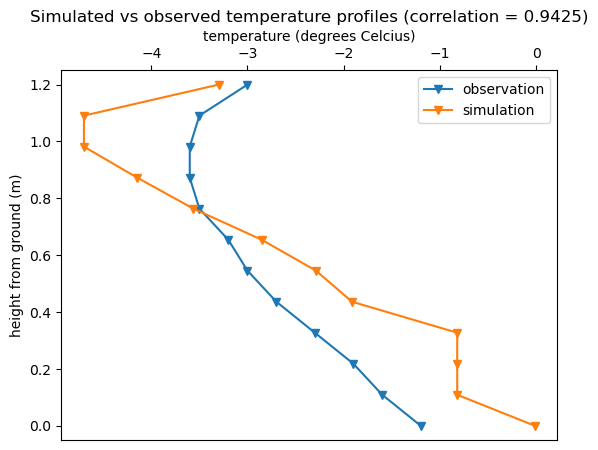

In [23]:
# Plot observed vs simulated temperature profiles

# Get profiles and correlation

observed_temp_profile.pop()
observed_temp_profile.pop()

# bottom_depth_temp = round( (len(observed_temp_profile)-1) * sampling_length, 1 )
simulated_temp_profile = temp_profile(bottom_depth_temp, sampling_length, depth_evolution[-1], temperature_evolution[-1])    #from bottom up
if len(simulated_temp_profile) == len(observed_temp_profile) -1:
    simulated_temp_profile.append(np.nan)
# simulated_temp_profile.pop()    

correlation_temp = p_correl_measure(simulated_temp_profile, observed_temp_profile)

# Create figure

fig = plt.figure()
ax = fig.add_subplot()

if start_from_top:
    depths_array = np.linspace(0, -bottom_depth_temp, len(observed_temp_profile))
    ax.plot(list(reversed(observed_temp_profile)), depths_array, marker='v', label='observation')
    ax.plot(list(reversed(simulated_temp_profile)), depths_array, marker='v', label='simulation')
else:
    depths_array = np.linspace(bottom_depth_temp, bottom_depth_temp+len(observed_temp_profile)*sampling_length, len(observed_temp_profile))
    ax.plot(list(observed_temp_profile), depths_array, marker='v', label='observation')
    ax.plot(list(simulated_temp_profile), depths_array, marker='v', label='simulation')    

ax.set_xlabel('temperature (degrees Celcius)')
ax.xaxis.tick_top()
ax.xaxis.set_label_position('top')

if start_from_top:
    ax.set_ylim(-bottom_depth_temp-sampling_length/2, sampling_length/2)
    ax.set_ylabel('depth from surface (m)')
else:
    ax.set_ylim(bottom_depth_temp-sampling_length/2, bottom_depth_temp + len(observed_temp_profile)*sampling_length + sampling_length/2)
    ax.set_ylabel('height from ground (m)')

plt.title('Simulated vs observed temperature profiles (correlation = ' + str(round(correlation_temp, 4)) + ')')
plt.legend()
plt.show()

In [ ]:
if save_figures:
    fig.savefig(directory_to_save_figs_in + fig_name_2, bbox_inches = 'tight')